In [1]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
from helpers import create_df
from helpers import get_peaks_and_valleys
from helpers import plot_df
from helpers import get_num_reps
from helpers import smooth_and_resample

In [ ]:
# 0 = bicep curl, 1 = shoulder press, 2 = row, 3 = rdl, 4 = squat 
training_files = ["../data2/bicep_curl/bicep_adam_set1_reps10_1.csv", 
                  "../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv", 
                  "../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv", 
                  "../data2/bicep_curl/bicep_jake_set1_reps10_1.csv", 
                  "../data2/bicep_curl/bicep_kamyar_set1_reps10_1.csv", 
                  "../data2/bicep_curl/bicep_mike_set1_reps10_1.csv", 
                  "../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv", 
                  "../data2/bicep_curl/bicep_udai_set1_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_adam_set1_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_andrew_set1_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_anuj_set1_rep10_1.csv", 
                  "../data2/shoulder_press/shoulder_kamyar_set1_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_mike_set1_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_udai_set1_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_suzan_set3_reps10_1.csv",
                  "../data2/row/row_adam_set1_reps10_1.csv", 
                  "../data2/row/row_andrew_set1_reps10_1.csv", 
                  "../data2/row/row_anuj_set1_rep10_1.csv", 
                  "../data2/row/row_jake_set1_reps12_1.csv", 
                  "../data2/row/row_kamyar_set1_reps10_1.csv", 
                  "../data2/row/row_mike_set1_reps10_1.csv", 
                  "../data2/row/row_suzan_set1_reps10_1.csv", 
                  "../data2/row/row_udai_set1_reps12_1.csv", 
                  "../data2/dead/dead_adam_set1_reps10_1.csv", 
                  "../data2/dead/dead_andrew_set1_reps10_1.csv", 
                  "../data2/dead/dead_anuj_set1_rep10_1.csv", 
                  "../data2/dead/dead_kamyar_set1_reps10_1.csv", 
                  "../data2/dead/dead_mike_set1_reps10_1.csv", 
                  "../data2/squat/squat_adam_set1_reps10_1.csv", 
                  "../data2/squat/squat_andrew_set1_reps10_1.csv", 
                  "../data2/squat/squat_anuj_set1_rep10_1.csv", 
                  "../data2/squat/squat_jake_set1_reps10_1.csv", 
                  "../data2/squat/squat_kamyar_set1_reps10_1.csv", 
                  "../data2/squat/squat_mike_set1_reps10_1.csv", 
                  "../data2/squat/squat_suzan_set1_reps10_1.csv", 
                  "../data2/squat/squat_udai_set1_reps10_1.csv",
                  "../data2/bicep_curl/bicep_udai_set3_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv", 
                  "../data2/row/row_udai_set3_reps10_1.csv", 
                  "../data2/dead/dead_udai_set1_reps10_1.csv", 
                  "../data2/squat/squat_udai_set3_reps10_1.csv",
                  "../data2/newDead/newdead_udai_set1_reps10_1.csv"] 
train_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 3, 4, 3] 

training_files_trim = [
    (8, -14),
    (93, -10),
    (21, -3),
    (21, 300)
]
validation_files = [
                    "../data2/bicep_curl/bicep_udai_set3_reps10_1.csv", 
                    "../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv", 
                    "../data2/row/row_udai_set3_reps10_1.csv", 
                    "../data2/dead/dead_udai_set1_reps10_1.csv", 
                    "../data2/squat/squat_udai_set3_reps10_1.csv"] 

validation_labels = [0, 1, 2, 3, 4] 

test_files = ["../data2/bicep_curl/bicep_adam_set2_reps10_1.csv", 
              "../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv", 
              "../data2/bicep_curl/bicep_anuj_set2_rep10_1.csv", 
              "../data2/bicep_curl/bicep_jake_set2_reps10_1.csv", 
              "../data2/bicep_curl/bicep_kamyar_set2_reps10_1.csv", 
              "../data2/bicep_curl/bicep_mike_set2_reps10_1.csv", 
              "../data2/bicep_curl/bicep_suzan_set2_reps10_1.csv", 
              "../data2/bicep_curl/bicep_udai_set2_reps10_1.csv", 
              "../data2/shoulder_press/shoulder_adam_set2_reps10_1.csv", 
              "../data2/shoulder_press/shoulder_andrew_set2_reps10_1.csv", 
              "../data2/shoulder_press/shoulder_anuj_set2_rep10_1.csv", 
              "../data2/shoulder_press/shoulder_kamyar_set2_reps10_1.csv", 
              "../data2/shoulder_press/shoulder_mike_set2_reps10_1.csv", 
              "../data2/shoulder_press/shoulder_suzan_set2_reps8_1.csv", 
              "../data2/shoulder_press/shoulder_suzan_set4_reps10_1.csv",
              "../data2/shoulder_press/shoulder_udai_set2_reps9_1.csv", 
              "../data2/row/row_adam_set2_reps10_1.csv", 
              "../data2/row/row_andrew_set2_reps10_1.csv", 
              "../data2/row/row_anuj_set2_rep10_1.csv", 
              "../data2/row/row_jake_set2_reps12_1.csv", 
              "../data2/row/row_kamyar_set2_reps10_1.csv", 
              "../data2/row/row_mike_set2_reps10_1.csv", 
              "../data2/row/row_suzan_set2_reps12_1.csv", 
              "../data2/row/row_udai_set2_reps12_1.csv", 
              "../data2/dead/dead_adam_set2_reps10_1.csv", 
              "../data2/dead/dead_andrew_set2_reps10_1.csv",
              "../data2/dead/dead_anuj_set2_rep10_1.csv", 
              "../data2/dead/dead_kamyar_set2_reps10_1.csv", 
              "../data2/dead/dead_mike_set2_reps10_1.csv", 
              "../data2/squat/squat_adam_set2_reps10_1.csv", 
              "../data2/squat/squat_andrew_set2_reps10_1.csv", 
              "../data2/squat/squat_anuj_set2_rep10_1.csv", 
              "../data2/squat/squat_jake_set2_reps10_1.csv", 
              "../data2/squat/squat_kamyar_set2_reps10_1.csv", 
              "../data2/squat/squat_mike_set2_reps10_1.csv", 
              "../data2/squat/squat_suzan_set2_reps10_1.csv", 
              "../data2/squat/squat_udai_set2_reps10_1.csv",
              "../data2/newDead/newdead_udai_set2_reps10_1.csv"] 

test_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3]

../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     304079   -0.834    3.319    9.444   0.098  -0.054   0.012
1     304082   -0.824    3.326    9.452   0.098  -0.054   0.012
2     304085   -0.824    3.326    9.452   0.097  -0.053   0.012
3     304089   -0.824    3.326    9.452   0.097  -0.053   0.012
4     304110   -0.846    3.269    9.446   0.122  -0.056   0.007


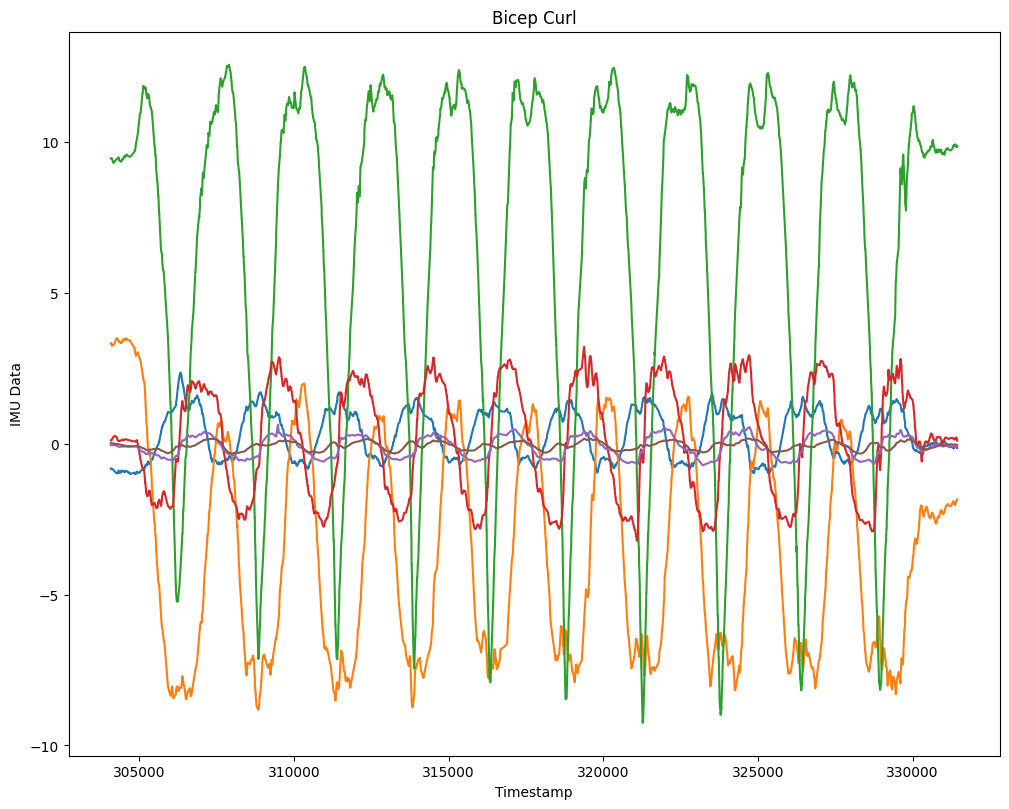

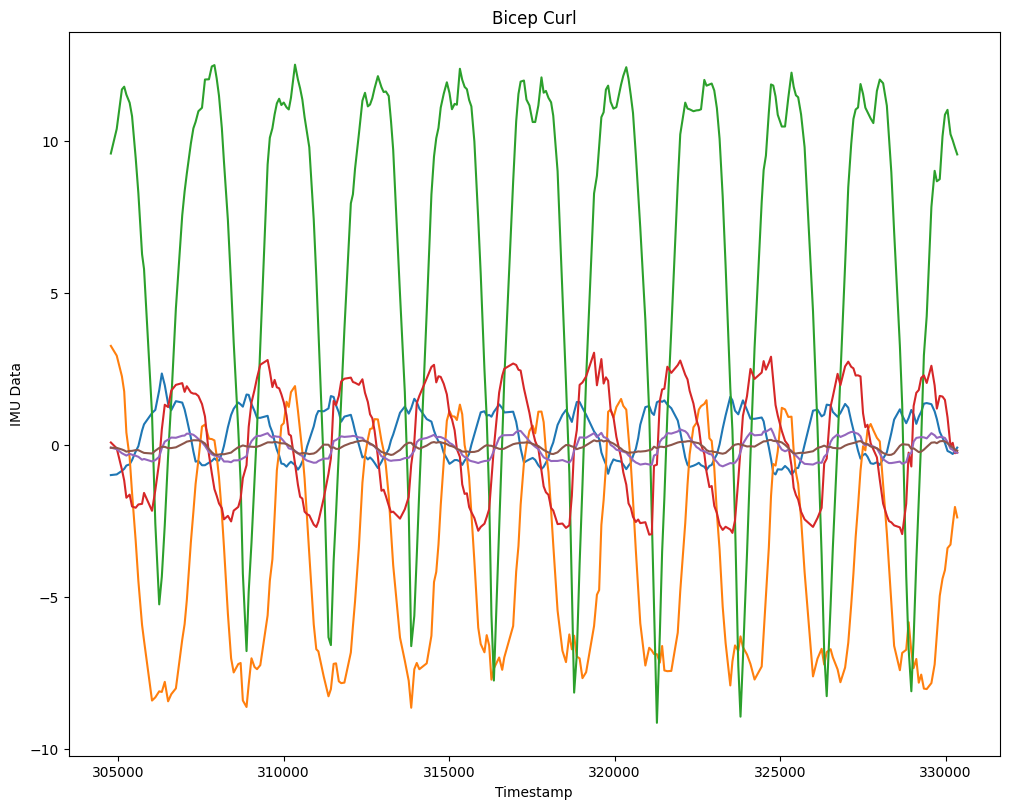

In [2]:
file = "../data2/bicep_curl/bicep_adam_set1_reps10_1.csv"
df = create_df(file)
plot_df(df, "Bicep Curl")
df = smooth_and_resample(df)
df = df[8:-14]
plot_df(df, "Bicep Curl")

../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0    1783092    0.522    4.887   -8.289  -0.454  -0.057  -0.042
1    1783096    0.536    4.859   -8.264  -0.519  -0.046  -0.043
2    1783099    0.536    4.859   -8.264  -0.519  -0.046  -0.043
3    1783103    0.536    4.859   -8.264  -0.519  -0.046  -0.043
4    1783126    0.474    4.851   -8.181  -0.552  -0.057  -0.049


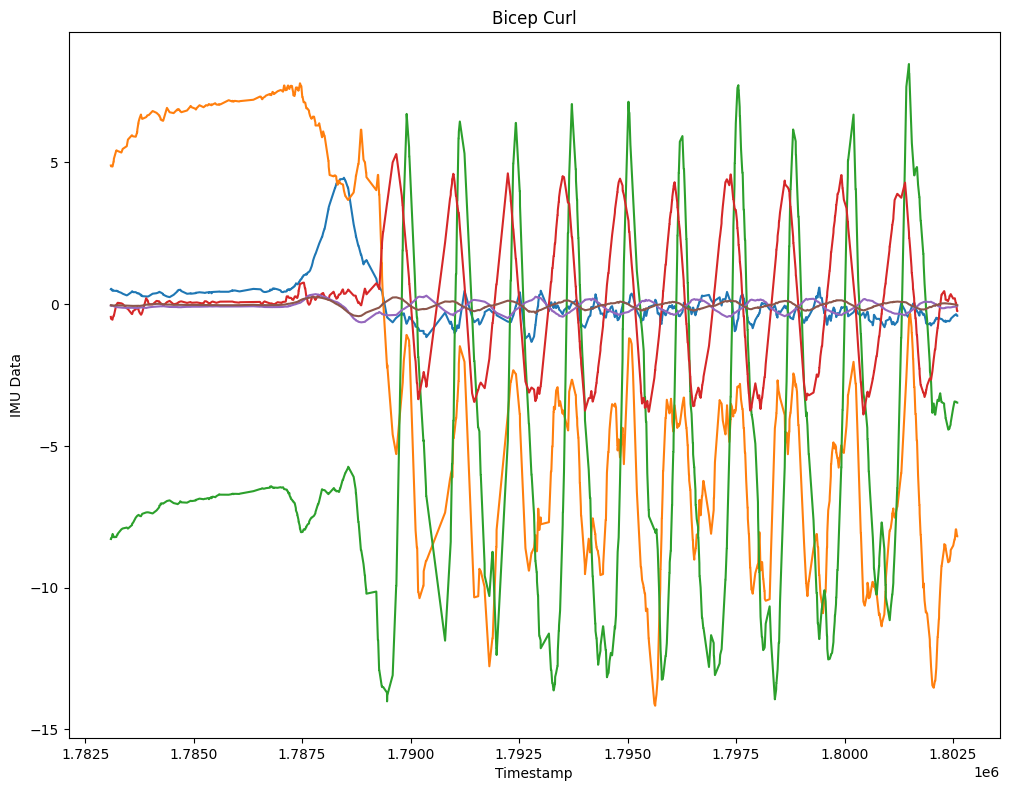

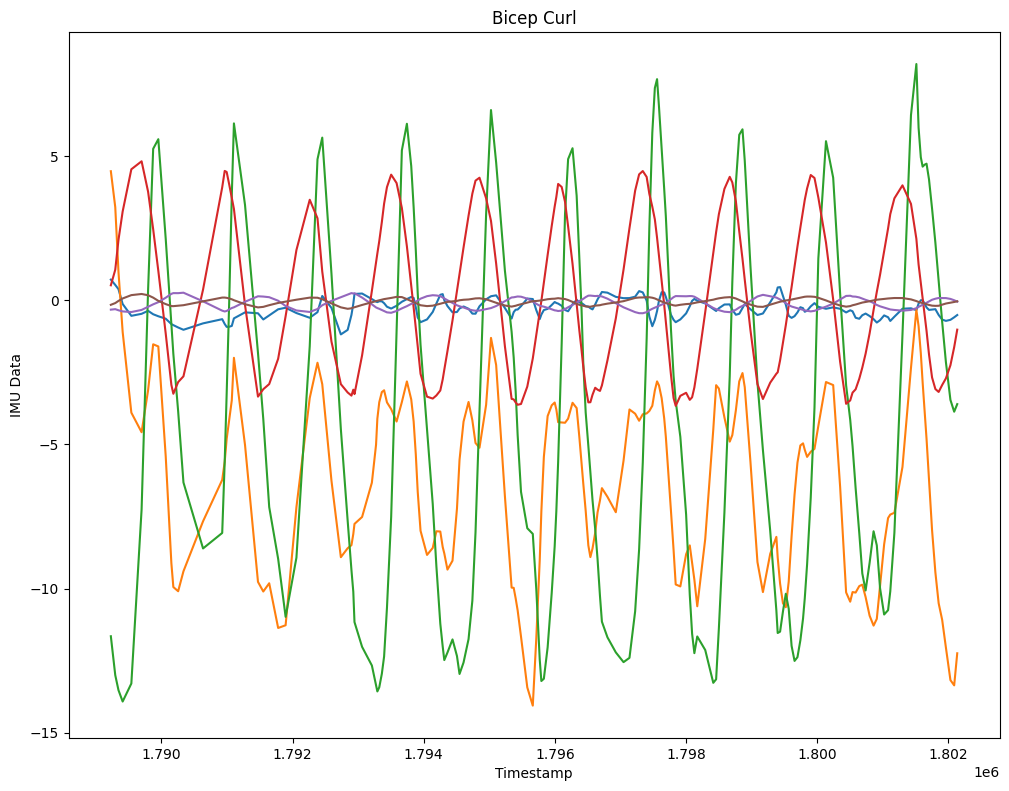

In [8]:
file = "../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv"
df = create_df(file)
plot_df(df, "Bicep Curl")
df = smooth_and_resample(df)
df = df[93:-10]
plot_df(df, "Bicep Curl")

../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     343675   -0.317   -6.084   -7.511  -0.007  -0.098  -0.040
1     343679   -0.317   -6.084   -7.511  -0.007  -0.098  -0.040
2     343682   -0.317   -6.084   -7.511  -0.007  -0.098  -0.040
3     343686   -0.318   -6.106   -7.482  -0.020  -0.095  -0.040
4     343708   -0.329   -6.055   -7.492  -0.033  -0.100  -0.043


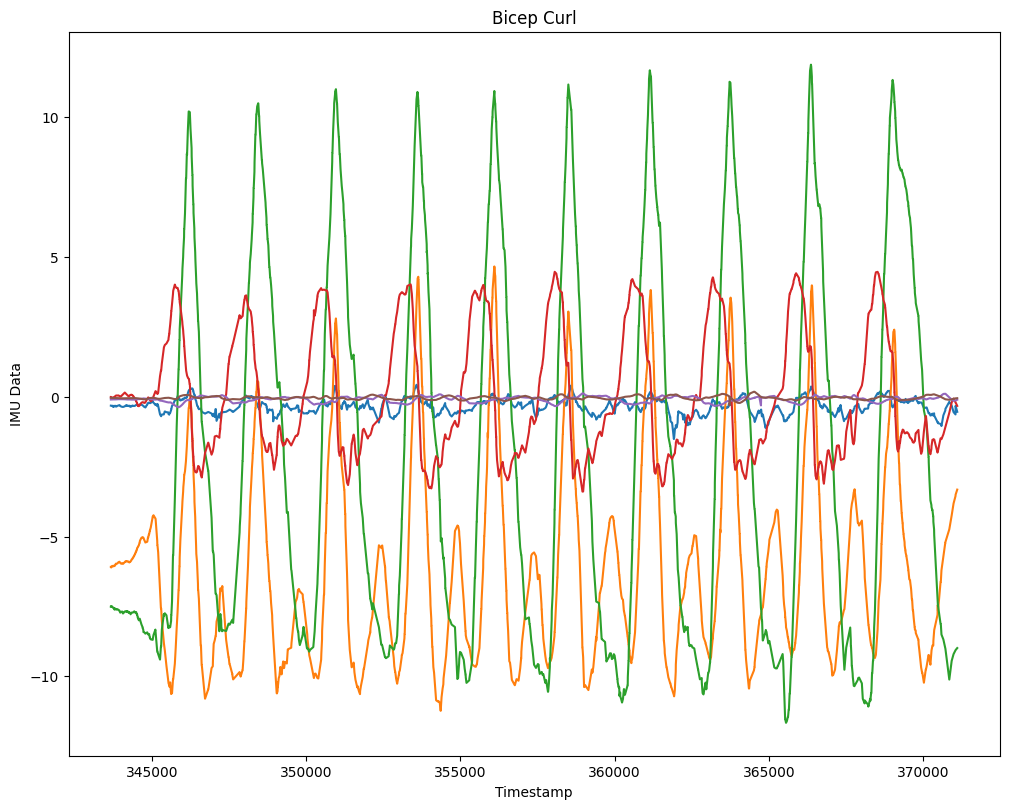

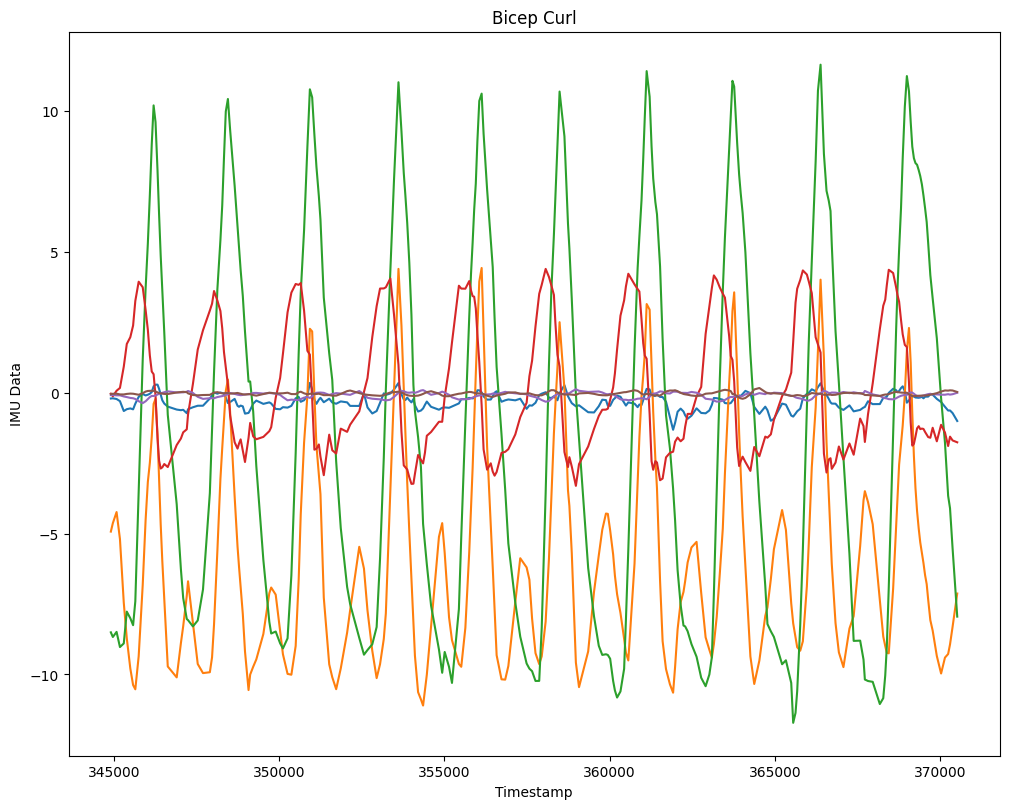

In [12]:
file = "../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv"
df = create_df(file)
plot_df(df, "Bicep Curl")
df = smooth_and_resample(df)
df = df[21:-3]
plot_df(df, "Bicep Curl")

../data2/bicep_curl/bicep_jake_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     290375   -1.572   -7.716    5.983  -0.204   0.038   0.077
1     290379   -1.625   -7.711    6.048  -0.161   0.027   0.073
2     290382   -1.625   -7.711    6.048  -0.161   0.027   0.073
3     290386   -1.687   -7.732    6.049  -0.161   0.027   0.068
4     290409   -1.742   -7.766    6.050  -0.053  -0.007   0.054


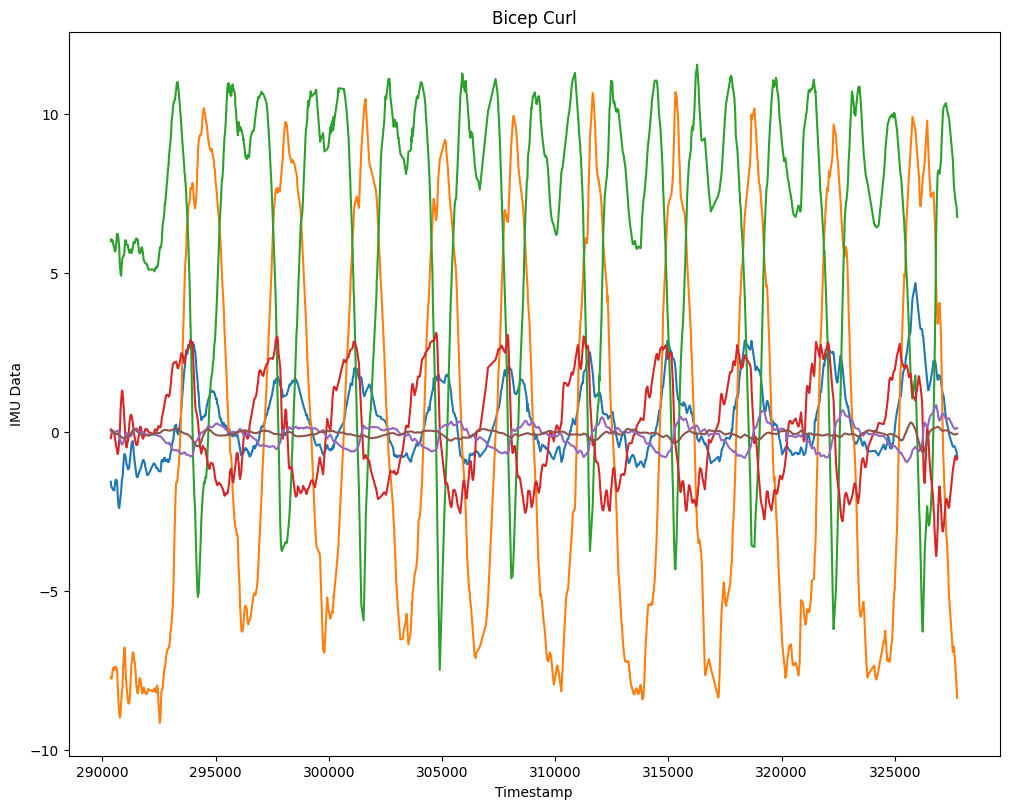

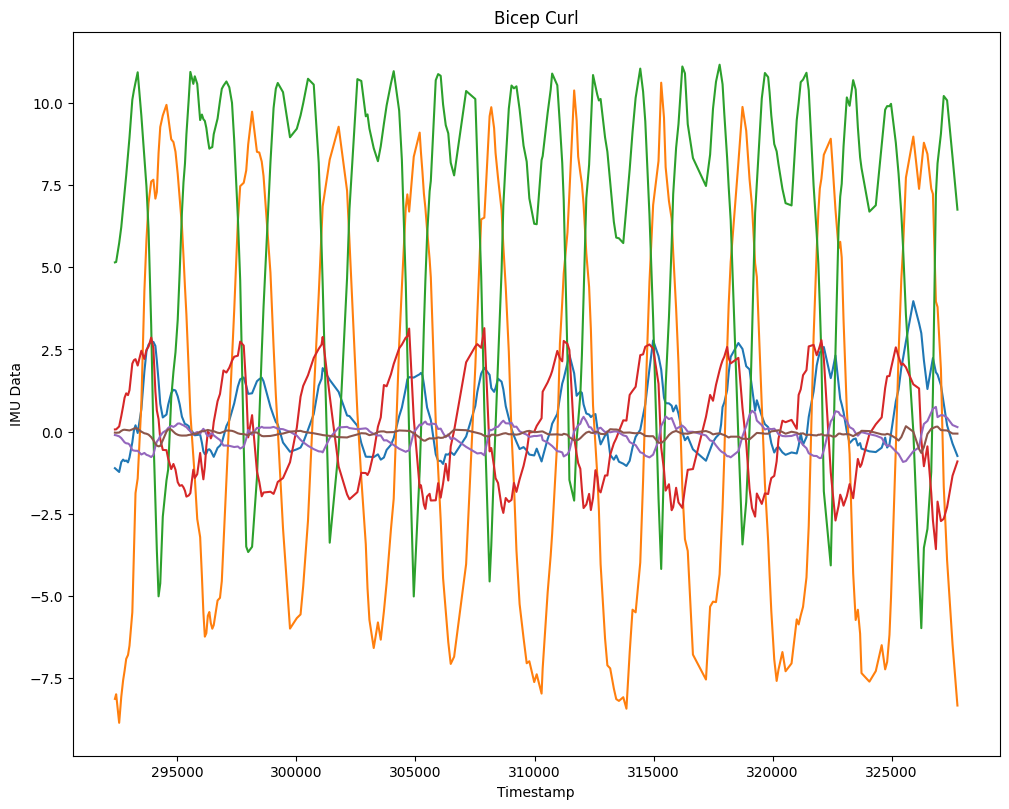

In [16]:
file = "../data2/bicep_curl/bicep_jake_set1_reps10_1.csv"
df = create_df(file)
plot_df(df, "Bicep Curl")
df = smooth_and_resample(df)
df = df[21:300]
plot_df(df, "Bicep Curl")